In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

1. **Load Data**

In [30]:
df_raw = pd.read_csv("C:/Users/venkat/Downloads/Dataset_Uber Traffic.csv")
df_raw

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041
...,...,...,...,...
48115,30/06/17 19:00,4,11,20170630194
48116,30/06/17 20:00,4,30,20170630204
48117,30/06/17 21:00,4,16,20170630214
48118,30/06/17 22:00,4,22,20170630224


**2. Clean the Data**

In [32]:
df_clean = df_raw.copy()

In [34]:
# Calculate the percentage of null values in each column
null_percentage = (df_clean.isnull().sum() / len(df_clean)) * 100
print(null_percentage)

DateTime    0.0
Junction    0.0
Vehicles    0.0
ID          0.0
dtype: float64


In [36]:
# Check for duplicate rows
duplicate_rows = df_clean.duplicated().sum()

# Display the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [38]:
df_clean.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [40]:
df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'])

C:\Users\venkat\AppData\Local\Temp\ipykernel_18280\2559344456.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'])


In [41]:
# Convert 'Junction' to a category for memory efficiency
df_clean['Junction'] = df_clean['Junction'].astype('category')

In [42]:
df_clean.dtypes

DateTime    datetime64[ns]
Junction          category
Vehicles             int64
ID                   int64
dtype: object

**3. Aggregate Traffic Data**

In [44]:
# Set 'DateTime' as the index to enable time-based grouping
df_agg = df_clean.set_index('DateTime')

In [45]:
# Group data by each 'Junction' and then aggregate the vehicle counts into hourly sums
hourly_traffic = df_agg.groupby('Junction').resample('H')['Vehicles'].sum().reset_index()

C:\Users\venkat\AppData\Local\Temp\ipykernel_18280\3537774641.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_traffic = df_agg.groupby('Junction').resample('H')['Vehicles'].sum().reset_index()
C:\Users\venkat\AppData\Local\Temp\ipykernel_18280\3537774641.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_traffic = df_agg.groupby('Junction').resample('H')['Vehicles'].sum().reset_index()


**4. Preprocess Data (Scaling)**

In [61]:
# This step prepares the data for machine learning models
df_processed = hourly_traffic.copy()

In [63]:
# Standardization (scales data to a mean of 0 and standard deviation of 1)
standard_scaler = StandardScaler()
df_processed['Vehicles_standardized'] = standard_scaler.fit_transform(df_processed[['Vehicles']])

In [65]:
print("Final Processed Data:")
print(df_processed.head())

Final Processed Data:
  Junction            DateTime  Vehicles  Vehicles_standardized
0        1 2015-01-11 00:00:00        15               0.105143
1        1 2015-01-11 01:00:00        13               0.001506
2        1 2015-01-11 02:00:00        10              -0.153950
3        1 2015-01-11 03:00:00         7              -0.309406
4        1 2015-01-11 04:00:00         9              -0.205768


**5. Feature Engineering**

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [70]:
df_features = df_processed.copy()

In [72]:
# First, ensure the 'DateTime' column is in the correct datetime format
df_features['DateTime'] = pd.to_datetime(df_features['DateTime'])

# Now, set the 'DateTime' column as the DataFrame's index
df_features.set_index('DateTime', inplace=True)

In [74]:
df_features['Hour'] = df_features.index.hour
df_features['DayOfWeek'] = df_features.index.dayofweek  # Monday=0, Sunday=6
df_features['Month'] = df_features.index.month
df_features['DayOfYear'] = df_features.index.dayofyear
print("✔️ Added time-based features (Hour, DayOfWeek, etc.).")

✔️ Added time-based features (Hour, DayOfWeek, etc.).


In [76]:
# We add traffic data from previous time steps.
# Important: We group by 'Junction' to ensure lags are junction-specific.
df_features['Lag_1_Hour'] = df_features.groupby('Junction')['Vehicles'].shift(1)
df_features['Lag_24_Hours'] = df_features.groupby('Junction')['Vehicles'].shift(24) # Same time yesterday
print("✔️ Added lag features (previous hour's traffic, etc.).")

✔️ Added lag features (previous hour's traffic, etc.).


C:\Users\venkat\AppData\Local\Temp\ipykernel_18280\1497212549.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_features['Lag_1_Hour'] = df_features.groupby('Junction')['Vehicles'].shift(1)
C:\Users\venkat\AppData\Local\Temp\ipykernel_18280\1497212549.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_features['Lag_24_Hours'] = df_features.groupby('Junction')['Vehicles'].shift(24) # Same time yesterday


In [78]:
public_holidays_2025 = [
    '2025-01-26',  # Republic Day
    '2025-03-14',  # Holi
    '2025-08-15',  # Independence Day
    '2025-10-02',  # Gandhi Jayanti
    '2025-10-20',  # Diwali
    '2025-12-25'   # Christmas Day
]
holiday_dates = pd.to_datetime(public_holidays_2025).date
df_features['Is_Weekend'] = (df_features['DayOfWeek'] >= 5).astype(int)
df_features['Is_Holiday'] = df_features.index.to_series().dt.date.isin(holiday_dates).astype(int)
print("✔️ Added binary indicators (Is_Weekend, Is_Holiday).")

✔️ Added binary indicators (Is_Weekend, Is_Holiday).


In [80]:
df_features.dropna(inplace=True)

print("\n--- Data with New Features ---")
print(df_features.head())


--- Data with New Features ---
                    Junction  Vehicles  Vehicles_standardized  Hour  \
DateTime                                                              
2015-01-12 00:00:00        1        21               0.416054     0   
2015-01-12 01:00:00        1        20               0.364236     1   
2015-01-12 02:00:00        1        18               0.260599     2   
2015-01-12 03:00:00        1        13               0.001506     3   
2015-01-12 04:00:00        1        14               0.053324     4   

                     DayOfWeek  Month  DayOfYear  Lag_1_Hour  Lag_24_Hours  \
DateTime                                                                     
2015-01-12 00:00:00          0      1         12        15.0          15.0   
2015-01-12 01:00:00          0      1         12        21.0          13.0   
2015-01-12 02:00:00          0      1         12        20.0          10.0   
2015-01-12 03:00:00          0      1         12        18.0           7.0   
20

**6. Feature Importance and Selection**

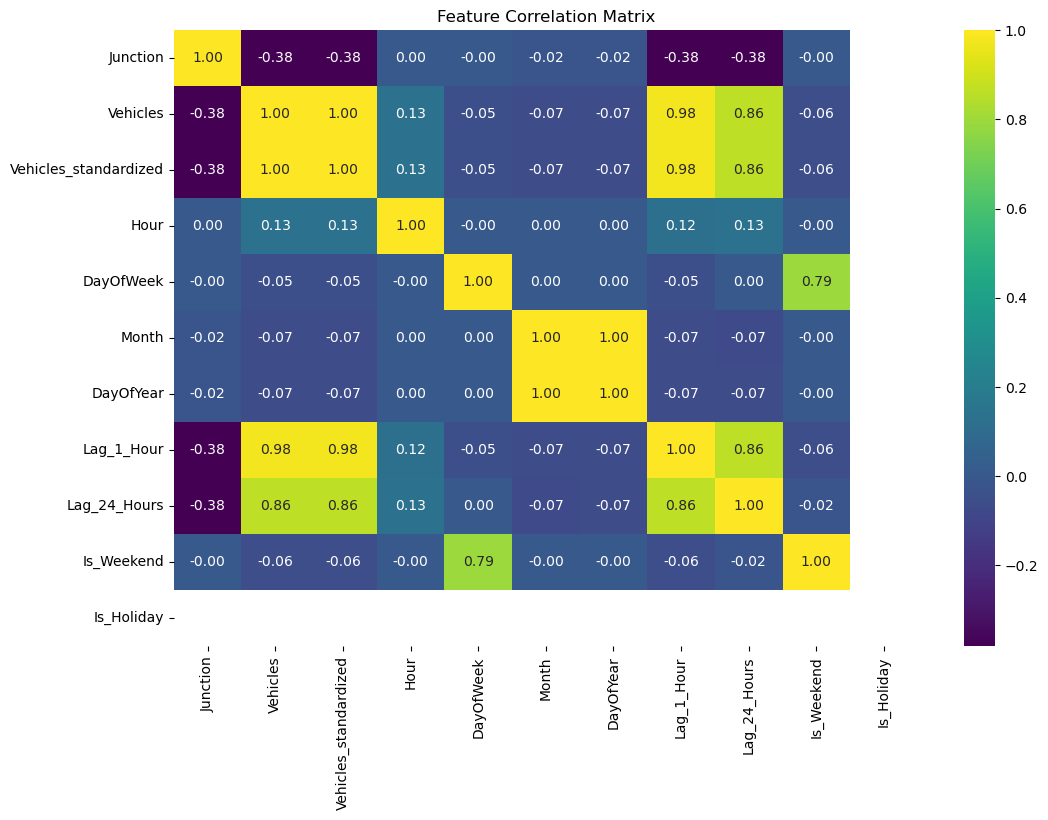

--- Correlation with Target (Vehicles) ---
Vehicles_standardized    1.000000
Vehicles                 1.000000
Lag_1_Hour               0.977049
Lag_24_Hours             0.862907
Hour                     0.134597
DayOfWeek               -0.048789
Is_Weekend              -0.056208
DayOfYear               -0.066467
Month                   -0.067336
Junction                -0.381002
Is_Holiday                    NaN
Name: Vehicles, dtype: float64


In [83]:
# Method A: Correlation Analysis
# Calculate the correlation of each feature with the target variable 'Vehicles'
correlation_matrix = df_features.corr()

# Plot a heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Display the correlation values with the target variable, sorted
print("--- Correlation with Target (Vehicles) ---")
print(correlation_matrix['Vehicles'].sort_values(ascending=False))


---  Feature Importance from Random Forest ---
        Feature  Importance
4    Lag_1_Hour    0.958426
0          Hour    0.015422
3     DayOfYear    0.009777
5  Lag_24_Hours    0.009709
1     DayOfWeek    0.003634
2         Month    0.002409
6    Is_Weekend    0.000622
7    Is_Holiday    0.000000


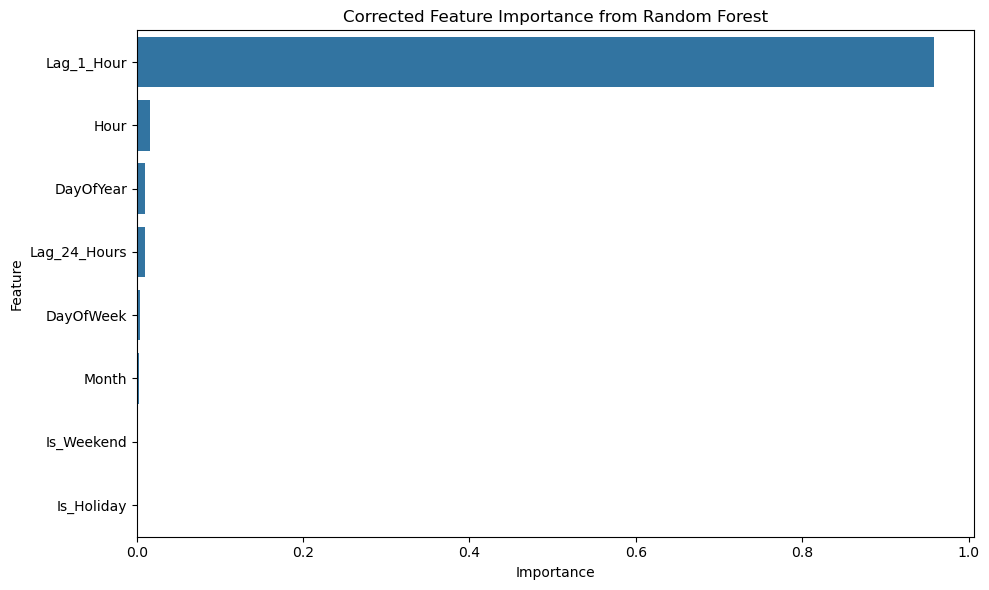

In [84]:
# Method B: Tree-Based Model (Random Forest)
# This method is more robust as it captures non-linear relationships.
# Define your features (X) and target (y)
X = df_features.drop(
    columns=['Vehicles', 'Vehicles_normalized', 'Vehicles_standardized', 'Junction'],
    errors='ignore'
)
y = df_features['Vehicles']

# Now, retrain your model with the corrected X and y
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get and display the new, meaningful feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n---  Feature Importance from Random Forest ---")
print(feature_importance_df)

# Plot the new importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Corrected Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

In [85]:
# Select features with an importance score greater than a threshold (e.g., 0.05)
influential_features = feature_importance_df[feature_importance_df['Importance'] > 0.05]['Feature'].tolist()

print(f"\n--- Selected Features (Importance > 0.05) ---")
print(influential_features)

# You can now create a final DataFrame for model training with only these features
X_final = df_features[influential_features]


--- Selected Features (Importance > 0.05) ---
['Lag_1_Hour']
